In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/images/349_IM-1697-2001.dcm.png
/kaggle/input/cxr-dataset/images/607_IM-2196-1001.dcm.png
/kaggle/input/cxr-dataset/images/2832_IM-1249-2001.dcm.png
/kaggle/input/cxr-dataset/images/699_IM-2263-2001.dcm.png
/kaggle/input/cxr-dataset/images/1931_IM-0602-2001.dcm.png
/kaggle/input/cxr-dataset/images/947_IM-2442-2001.dcm.png
/kaggle/input/cxr-dataset/images/2932_IM-1335-1001.dcm.png
/kaggle/input/cxr-dataset/images/2303_IM-0882-1001.dcm.png
/kaggle/input/cxr-dataset/images/291_IM-1313-2001.dcm.png
/kaggle/input/cxr-dataset/images/1790_IM-0515-1001.dcm.png
/kaggle/input/cxr-dataset/images/3489_IM-1696-2001.dcm.png
/kaggle/input/cxr-dataset/images/3275_IM-1556-1002001.dcm.png
/kaggle/input/cxr-dataset/images/286_IM-1267-3001.dcm.png
/kaggle/input/cxr-dataset/images/3071_IM-1433-1001.dcm.png
/kaggle/input/cxr-dataset/images/1991_IM-0648-1001.dcm.png
/kaggle/input/cxr-dataset/images/3083_

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Ensure that the NLTK sentence tokenizer is downloaded
nltk.download('punkt')

2024-05-28 17:02:40.773661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 17:02:40.773905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 17:02:40.936940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [5]:
image_path = "/kaggle/input/cxr-dataset/images/"
images = glob(image_path + "*.png")
len(images)

7470

In [6]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [7]:
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [8]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        return uid, images, projections, findings

In [9]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings = paired_dataset.get_sample()

In [10]:
def display_sample(uid, images, projections, findings):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(image_path, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)

UID: 1991


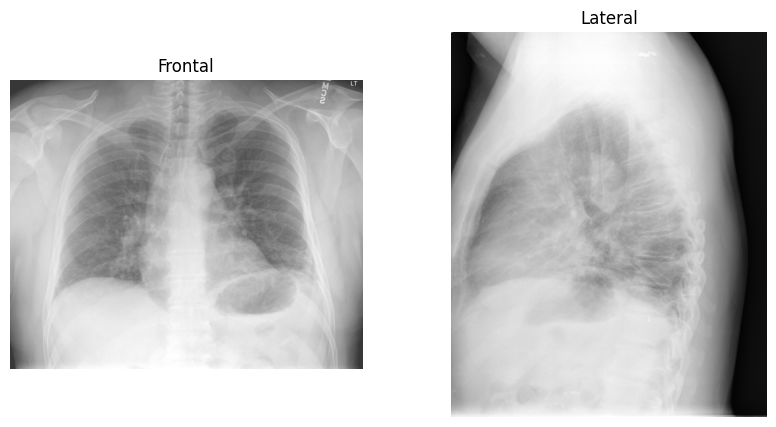

Findings: The heart is normal in size. The mediastinum is stable. The lungs are hypoinflated. There are XXXX streaky opacities predominantly in the left lung base possibly related to scarring and atelectasis. XXXX B-lines are also noted. Definite infiltrate is not excluded. There is no large effusion.


In [11]:
display_sample(uid, images, projections, findings)

In [13]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

# Setting up Language Model

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [15]:
findings_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [16]:
impressions_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].impression.dropna()]

# Desription of Findings Corpus

In [17]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

# Desription of Impressions Corpus

In [18]:
pd.Series([len(x) for x in impressions_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3440.000000
mean       17.939244
std        19.098879
min         2.000000
25%         8.000000
50%        10.000000
75%        21.000000
80%        26.000000
90%        42.000000
95%        57.000000
max       205.000000
dtype: float64

# Generating Language model for findings

In [19]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

# Create dataset
dataset = GPT2Dataset(findings_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [20]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [21]:
sample_reports = list(reports_df[reports_df.uid.isin(test_uids)].findings.dropna().sample(2))

In [22]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("---------\n")
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Stable postoperative and degenerative changes of the XXXX. Stable degenerative disc disease of the thoracic spine.
---------

Generated report:
 Normal heart size and mediastinal volume.

The study was published in the journal Circulation.
------------
Sample report:
 Heart size and mediastinal contour are normal. Pulmonary vascularity is normal. Lungs are clear. No pleural effusions or pneumothoraces.
---------

Generated report:
 Heart size and mediastinal contour are also important for the development of the brain.

The brain is a complex organ that is divided into three parts: the cerebellum, the hippocampus, and the ventral tegmental area. The cerebrum is the part of our brain that contains the most information about our body and our emotions. It is also the place where we learn and experience the world. In the case of a person with Alzheimer's disease,

In [23]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3 # Having larger number of epochs here was leading to complete overfitting on the report content
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

100%|██████████| 751/751 [36:45<00:00,  2.94s/it]


Epoch 0 completed


100%|██████████| 751/751 [36:05<00:00,  2.88s/it]


Epoch 1 completed


100%|██████████| 751/751 [36:04<00:00,  2.88s/it]

Epoch 2 completed


In [24]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("------------")
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Stable postoperative and degenerative changes of the XXXX. Stable degenerative disc disease of the thoracic spine.
------------
Generated report:
 Normal heart size and mediastinal contours. No focal airspace consolidation. There is no pneumothorax or pleural effusion.
------------
Sample report:
 Heart size and mediastinal contour are normal. Pulmonary vascularity is normal. Lungs are clear. No pleural effusions or pneumothoraces.
------------
Generated report:
 Heart size and mediastinal contour are normal. Pulmonary vascularity is normal in caliber. No focal consolidation, pleural effusion, or pneumothorax identified. Visualized osseous structures appear intact.
------------


In [25]:
model.save_pretrained('/kaggle/working/gpt-2-model_findings')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer_findings')

('/kaggle/working/gpt-2-tokenizer_findings/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer_findings/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer_findings/vocab.json',
 '/kaggle/working/gpt-2-tokenizer_findings/merges.txt',
 '/kaggle/working/gpt-2-tokenizer_findings/added_tokens.json')

In [26]:
import shutil

# Define the paths
model_dir = '/kaggle/working/gpt-2-model_findings'
tokenizer_dir = '/kaggle/working/gpt-2-tokenizer_findings'
output_zip_path = '/kaggle/working/gpt-2-model_tokenizer_findings.zip'

# Create a zip file
shutil.make_archive('/kaggle/working/gpt-2-model_tokenizer_findings', 'zip', '/kaggle/working', 'gpt-2-model_findings')
shutil.make_archive('/kaggle/working/gpt-2-tokenizer_findings', 'zip', '/kaggle/working', 'gpt-2-tokenizer_findings')


'/kaggle/working/gpt-2-tokenizer_findings.zip'

In [27]:
from IPython.display import FileLink

# Link to download the model zip file
FileLink(r'/kaggle/working/gpt-2-model_findings.zip')
# Link to download the tokenizer zip file
FileLink(r'/kaggle/working/gpt-2-tokenizer_findings.zip')


/kaggle/working/gpt-2-tokenizer_findings.zip

# Generate Language Model for Impressions

In [28]:
tokenizer2 = GPT2Tokenizer.from_pretrained('gpt2')

In [29]:
class GPT2Dataset2(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer2.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

def collate_batch2(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer2.pad_token_id
    if pad_id is None:
        pad_id = tokenizer2.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

# Create dataset
dataset2 = GPT2Dataset2(impressions_corpus, max_length=128)  # Adjust max_length as needed
dataloader2 = DataLoader(dataset2, batch_size=4, shuffle=True, collate_fn=collate_batch2)

In [30]:
model2 = GPT2LMHeadModel.from_pretrained('gpt2')
model2 = model2.to(device)

In [31]:
sample_reports2 = list(reports_df[reports_df.uid.isin(test_uids)].impression.dropna().sample(2))

In [32]:
model2.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports2:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer2.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model2.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer2.eos_token_id
        )
        generated_text = tokenizer2.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports2, generated_texts):
    print("Sample report:\n", smp)
    print("---------\n")
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 No active disease.
---------

Generated report:
 No active disease.

The study was published in the journal Nature Communications.
------------
Sample report:
 No acute cardiopulmonary process.
---------

Generated report:
 No acute cardiopulmonary process.

The patient was admitted to the hospital with a minor cardiac arrest. The patient's condition was stabilized and he was discharged from the ICU. He was placed in a ventilator and placed into a cardiac monitor. After the ventilated ventricle was opened, the patient underwent a chest x-ray. A CT scan revealed that the heart was beating. There was no evidence of a heart attack. No other cardiac events were reported.
------------


In [33]:
model2.train()
optimizer2 = AdamW(model2.parameters(), lr=5e-5)

NUM_EPOCHS = 3 # Having larger number of epochs here was leading to complete overfitting on the report content
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(dataloader2):
        optimizer2.zero_grad()
        outputs = model2(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()

    print(f'Epoch {epoch} completed')

100%|██████████| 860/860 [28:14<00:00,  1.97s/it]


Epoch 0 completed


100%|██████████| 860/860 [26:57<00:00,  1.88s/it]  


Epoch 1 completed


100%|██████████| 860/860 [26:47<00:00,  1.87s/it]

Epoch 2 completed


In [34]:
model2.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports2:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer2.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model2.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer2.eos_token_id
        )
        generated_text = tokenizer2.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports2, generated_texts):
    print("Sample report:\n", smp)
    print("------------")
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 No active disease.
------------
Generated report:
 No active disease.
------------
Sample report:
 No acute cardiopulmonary process.
------------
Generated report:
 No acute cardiopulmonary process.
------------


In [35]:
model2.save_pretrained('/kaggle/working/gpt-2-model_impressions')
tokenizer2.save_pretrained('/kaggle/working/gpt-2-tokenizer_impressions')


('/kaggle/working/gpt-2-tokenizer_impressions/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer_impressions/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer_impressions/vocab.json',
 '/kaggle/working/gpt-2-tokenizer_impressions/merges.txt',
 '/kaggle/working/gpt-2-tokenizer_impressions/added_tokens.json')

In [36]:
import shutil

# Define the paths
model2_dir = '/kaggle/working/gpt-2-model_impressions'
tokenizer2_dir = '/kaggle/working/gpt-2-tokenizer_impressions'
model2_zip_path = '/kaggle/working/gpt-2-model_impressions.zip'
tokenizer2_zip_path = '/kaggle/working/gpt-2-tokenizer_impressions.zip'

# Create a zip file for the second model
shutil.make_archive(model2_zip_path.replace('.zip', ''), 'zip', '/kaggle/working', 'gpt-2-model_impressions')
# Create a zip file for the second tokenizer
shutil.make_archive(tokenizer2_zip_path.replace('.zip', ''), 'zip', '/kaggle/working', 'gpt-2-tokenizer_impressions')


'/kaggle/working/gpt-2-tokenizer_impressions.zip'

In [37]:
from IPython.display import FileLink

# Link to download the model zip file
display(FileLink(r'/kaggle/working/gpt-2-model_impressions.zip'))
# Link to download the tokenizer zip file
display(FileLink(r'/kaggle/working/gpt-2-tokenizer_impressions.zip'))


/kaggle/working/gpt-2-model_impressions.zip

/kaggle/working/gpt-2-tokenizer_impressions.zip